In [2]:
import zipfile
import os
zip_file_path = 'cashflow_data.zip'
extract_path = os.path.dirname(zip_file_path)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.dirname(zip_file_path))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


consumers = pd.read_parquet("cashflow/consumer_data.parquet")
transactions = pd.read_parquet('cashflow/transactions.parquet')
categories = pd.read_csv('transaction_categories.csv')

#after import to the file, we can delete the unzip folder. 
shutil.rmtree('cashflow')

## Feature Engineering

In [4]:
transactions = pd.merge(transactions, categories, left_on='category', right_on='code', how='left')
merged_df = pd.merge(transactions, consumers, left_on='masked_consumer_id', right_on='masked_consumer_id', how='left')
for col in merged_df.select_dtypes(include=['float64']).columns:
    merged_df[col] = merged_df[col].astype('float32')
merged_df['ClientID'] = merged_df['masked_consumer_id'].str[:3]

# Map ClientID to product type
client_product_map = {
    'C01': 'Personal Loans',
    'C02': 'Payday Loans',
    'C03': 'Credit Cards',
    'C04': 'Personal Loans'
}

merged_df['Product'] = merged_df['ClientID'].map(client_product_map)
merged_df = merged_df.drop(columns=['ClientID', 'masked_transaction_id', 'code', 'description'])
merged_df['posted_date'] = pd.to_datetime(merged_df['posted_date'])
merged_df['posted_year'] = merged_df['posted_date'].dt.year
category_mapping = dict()
for row in categories.iterrows():
    category_mapping[row[1]['code']] = row[1]['description']


In [5]:
merged_df = merged_df.dropna()
# Convert 'posted_date' to datetime format
merged_df['posted_date'] = pd.to_datetime(merged_df['posted_date'])
merged_df['evaluation_date'] = pd.to_datetime(merged_df['evaluation_date'])


In [6]:
income_codes = list(transactions[transactions['amount'] > 0]['category'].unique())
spending_codes = list(transactions[transactions['amount'] < 0]['category'].unique())
loan_related_codes = [12, 32, 35, 36]#'LOAN','MORTGAGE', 'BNPL' (Buy Now Pay Later), 'AUTO_LOAN'

In [7]:
def get_yearly_related_feature(lst,category_name):
    #takes a list of category code and return a df which groupby the consumer id, year, and aggregate on sum and mean.
    df = merged_df[merged_df['category'].isin(lst)].groupby(["masked_consumer_id", "posted_year"]).agg(
        total_transactions = ('amount', sum),
        mean_transactions = ('amount', 'mean')
    )

    # Pivot the DataFrame to have one row per consumer with columns for each year
    df_pivot = df.reset_index().pivot(index='masked_consumer_id', columns='posted_year')
    print(df_pivot.columns)
    # Flatten the column names
    df_pivot.columns = [f'{category_name}_{year}_{agg}' for year, agg in df_pivot.columns]

    return df_pivot

paycheck_features = get_yearly_related_feature([3],"PAYCHECK")
income_related_features2 = get_yearly_related_feature(income_codes,"INCOME")
spending_related_feature = get_yearly_related_feature(spending_codes,"SPENDING")
loan_related_feature = get_yearly_related_feature(loan_related_codes,"LOAN")


MultiIndex([('total_transactions', 2018.0),
            ('total_transactions', 2019.0),
            ('total_transactions', 2020.0),
            ('total_transactions', 2021.0),
            ('total_transactions', 2022.0),
            ('total_transactions', 2023.0),
            ( 'mean_transactions', 2018.0),
            ( 'mean_transactions', 2019.0),
            ( 'mean_transactions', 2020.0),
            ( 'mean_transactions', 2021.0),
            ( 'mean_transactions', 2022.0),
            ( 'mean_transactions', 2023.0)],
           names=[None, 'posted_year'])
MultiIndex([('total_transactions', 2018.0),
            ('total_transactions', 2019.0),
            ('total_transactions', 2020.0),
            ('total_transactions', 2021.0),
            ('total_transactions', 2022.0),
            ('total_transactions', 2023.0),
            ( 'mean_transactions', 2018.0),
            ( 'mean_transactions', 2019.0),
            ( 'mean_transactions', 2020.0),
            ( 'mean_transactions', 

In [8]:
consumer_features1 = merged_df.groupby('masked_consumer_id').agg(
    transactions_count=('masked_consumer_id', 'count'),
    max_debit_amount=('amount', lambda x: x[x < 0].max()),
    min_debit_amount=('amount', lambda x: x[x < 0].min()),
    average_debit_amount=('amount', lambda x: x[x < 0].mean()),
    max_credit_amount=('amount', lambda x: x[x > 0].max()),
    min_credit_amount=('amount', lambda x: x[x > 0].min()),
    average_credit_amount=('amount', lambda x: x[x > 0].mean()),
    count_of_credits=('amount', lambda x: x[x > 0].count()),
    count_of_debits=('amount', lambda x: x[x < 0].count()),
    #Zichen added feature
    
).reset_index()

# Fill NaN values with 0
consumer_features1.fillna(0, inplace=True)
consumer_features2 = merged_df[['masked_consumer_id', 'FPF_TARGET', 'evaluation_date', 'total_balance']].drop_duplicates()

In [34]:
# Calculate days span for each consumer
merged_df['days_span'] = (merged_df['evaluation_date'] - merged_df.groupby('masked_consumer_id')['posted_date'].transform('min')).dt.days.clip(lower=1)

# Calculate total debit and credit sums for each consumer
debit_credit_sums = merged_df.groupby('masked_consumer_id').apply(
    lambda df: pd.Series({
        'total_debit': df[df['amount'] < 0]['amount'].sum(),
        'total_credit': df[df['amount'] > 0]['amount'].sum(),
        'transaction_count': df['posted_date'].count(),
        'days_span': df['days_span'].iloc[0]
    })
)

# Calculate averages for debits, credits, and transaction frequency
debit_credit_sums['average_debit_spending'] = debit_credit_sums['total_debit'] / debit_credit_sums['days_span']
debit_credit_sums['average_credit_spending'] = debit_credit_sums['total_credit'] / debit_credit_sums['days_span']
debit_credit_sums['average_transaction_frequency'] = debit_credit_sums['transaction_count'] / debit_credit_sums['days_span']

# Calculate total amounts for specific categories
for code, cat in category_mapping.items():
    category_sum = merged_df[merged_df['category'] == code].groupby('masked_consumer_id')['amount'].sum()
    debit_credit_sums[f'total_{cat}'] = category_sum

# Calculate average amounts for specific categories
for cat in category_mapping.values():
    debit_credit_sums[f'average_{cat}'] = debit_credit_sums[f'total_{cat}'] / debit_credit_sums['days_span']
debit_credit_sums.fillna(0, inplace=True)
debit_credit_sums.reset_index(inplace=True)
consumer_data = consumer_features1.merge(consumer_features2, on='masked_consumer_id')
consumer_data = consumer_data.merge(debit_credit_sums, on='masked_consumer_id')

In [64]:
consumer_data.columns

Index(['masked_consumer_id', 'transactions_count', 'max_debit_amount',
       'min_debit_amount', 'average_debit_amount', 'max_credit_amount',
       'min_credit_amount', 'average_credit_amount', 'count_of_credits',
       'count_of_debits', 'FPF_TARGET', 'evaluation_date', 'transaction_count',
       'days_span', 'average_debit_spending', 'average_credit_spending',
       'average_transaction_frequency', 'average_SELF_TRANSFER',
       'average_EXTERNAL_TRANSFER', 'average_DEPOSIT', 'average_PAYCHECK',
       'average_MISCELLANEOUS', 'average_PAYCHECK_PLACEHOLDER',
       'average_REFUND', 'average_INVESTMENT_INCOME', 'average_OTHER_BENEFITS',
       'average_UNEMPLOYMENT_BENEFITS', 'average_SMALL_DOLLAR_ADVANCE',
       'average_TAX', 'average_LOAN', 'average_INSURANCE',
       'average_FOOD_AND_BEVERAGES', 'average_UNCATEGORIZED',
       'average_GENERAL_MERCHANDISE', 'average_AUTOMOTIVE',
       'average_GROCERIES', 'average_ATM_CASH', 'average_ENTERTAINMENT',
       'average_TRAVE

In [65]:
cols_to_drop = [col for col in consumer_data.columns if col.startswith('total_')]
consumer_data = consumer_data.drop(columns=cols_to_drop)
working_data = consumer_data.copy()
# working_data['credit_to_debit_ratio'] = working_data['average_credit_amount'] / working_data['average_debit_amount'].abs()
working_data['investment_to_income_ratio'] = working_data['average_INVESTMENT_INCOME'] / (working_data['average_PAYCHECK'] + 1e-5)  # Adding a small number to avoid division by zero
working_data['debit_volatility'] = working_data.groupby('masked_consumer_id')['average_debit_amount'].transform(np.std)
working_data['credit_volatility'] = working_data.groupby('masked_consumer_id')['average_credit_amount'].transform(np.std)
working_data['max_min_debit_ratio'] = working_data['max_debit_amount'] / (working_data['min_debit_amount'].abs() + 1e-5)  # To avoid division by zero
working_data['high_cost_debit_flag'] = (working_data['max_debit_amount'] < -5000).astype(int)  # High cost debit transaction
working_data['low_cost_credit_flag'] = (working_data['min_credit_amount'] < 100).astype(int)  # Low cost credit transaction
working_data['transactions_per_day'] = working_data['transactions_count'] / working_data['days_span']
working_data['cumulative_credits'] = working_data.groupby('masked_consumer_id')['average_credit_amount'].cumsum()
working_data['cumulative_debits'] = working_data.groupby('masked_consumer_id')['average_debit_amount'].cumsum()
working_data['has_education_transactions'] = (working_data['average_EDUCATION'] != 0).astype(int)
working_data['log_max_credit'] = np.log(working_data['max_credit_amount'] + 1)  # Log of max credit amount to reduce skewness
working_data['log_max_debit'] = np.log(working_data['max_debit_amount'].abs() + 1)  # Log of absolute max debit amount to reduce skewness
working_data['extreme_healthcare_spending'] = (working_data['average_HEALTHCARE_MEDICAL'] < -100).astype(int)
working_data['extreme_education_spending'] = (working_data['average_EDUCATION'] < -100).astype(int)
working_data['proportion_credits'] = working_data['count_of_credits'] / working_data['transactions_count']
working_data['proportion_debits'] = working_data['count_of_debits'] / working_data['transactions_count']
# Standard deviation of transaction amounts as an indicator of financial stability
working_data['std_transaction_amount'] = working_data[['average_debit_amount', 'average_credit_amount']].std(axis=1)
# Ratio of total credits to total debits to indicate spending efficiency
working_data['spending_efficiency'] = working_data['average_credit_amount'] / (working_data['average_debit_amount'].abs() + 1e-5)
# Assuming 'evaluation_date' is in YYYY-MM-DD format and you want to capture seasonal effects
working_data['month'] = pd.to_datetime(working_data['evaluation_date']).dt.month
working_data['is_high_spending_season'] = working_data['month'].isin([11, 12]).astype(int)  # Nov and Dec as high spending months
# Measure variability in transaction frequency to assess stability
working_data['frequency_stability'] = working_data.groupby('masked_consumer_id')['transactions_per_day'].transform(np.std)
# Flags for unusual spending or income patterns
working_data['high_credit_frequency'] = (working_data['count_of_credits'] > working_data['count_of_credits'].quantile(0.95)).astype(int)
working_data['low_debit_frequency'] = (working_data['count_of_debits'] < working_data['count_of_debits'].quantile(0.05)).astype(int)
working_data2 = working_data.copy()
# working_data2['CLV'] = working_data2.groupby('masked_consumer_id').cumsum()['average_credit_amount'] - working_data2.groupby('masked_consumer_id').cumsum()['average_debit_amount']
# Create rolling averages for credits and debits to capture trends over time
working_data2.sort_values(by=['masked_consumer_id', 'evaluation_date'], inplace=True)  # Ensure data is sorted
working_data2['rolling_avg_credits'] = working_data2.groupby('masked_consumer_id')['average_credit_amount'].rolling(window=12, min_periods=1).mean().reset_index(level=0, drop=True)
working_data2['rolling_avg_debits'] = working_data2.groupby('masked_consumer_id')['average_debit_amount'].rolling(window=12, min_periods=1).mean().reset_index(level=0, drop=True)
# Extract day of week from date and create dummy variables for weekdays
working_data2['day_of_week'] = pd.to_datetime(working_data2['evaluation_date']).dt.dayofweek
working_data2 = pd.get_dummies(working_data2, columns=['day_of_week'], prefix='dow')
# Create an interaction term between credits and debits to explore their combined effect on the target variable
working_data2['credit_debit_interaction'] = working_data2['average_credit_amount'] * working_data2['average_debit_amount']
# Create lag features for credit and debit amounts to capture previous transaction values
working_data2['lag1_credit'] = working_data2.groupby('masked_consumer_id')['average_credit_amount'].shift(1)
working_data2['lag1_debit'] = working_data2.groupby('masked_consumer_id')['average_debit_amount'].shift(1)
# Calculate the percentage change from the previous record to capture growth or contraction
working_data2['pct_change_credit'] = working_data2.groupby('masked_consumer_id')['average_credit_amount'].pct_change()
working_data2['pct_change_debit'] = working_data2.groupby('masked_consumer_id')['average_debit_amount'].pct_change()
# Flags to identify unusually high or low transactions
working_data2['extreme_high_credit'] = (working_data2['average_credit_amount'] > working_data2['average_credit_amount'].quantile(0.99)).astype(int)
working_data2['extreme_low_debit'] = (working_data2['average_debit_amount'] < working_data2['average_debit_amount'].quantile(0.01)).astype(int)

In [90]:
spx500 = working_data2.copy()
spx500['Essential_vs_NonEssential'] = spx500[['average_FOOD_AND_BEVERAGES', 'average_GROCERIES', 'average_HEALTHCARE_MEDICAL']].sum(axis=1) / spx500[['average_ENTERTAINMENT', 'average_TRAVEL', 'average_HOME_IMPROVEMENT']].sum(axis=1)
spx500['total_credit'] = spx500['average_credit_amount'] * spx500['count_of_credits']
spx500['total_debit'] = spx500['average_debit_amount'] * spx500['count_of_debits']
spx500['net_flow'] = spx500['total_credit'] - spx500['total_debit']
spx500['credit_debit_ratio'] = spx500['total_credit'] / spx500['total_debit']
# Spending Patterns
spx500['entertainment_to_total_spending'] = spx500['average_ENTERTAINMENT'] / spx500['average_credit_spending']
spx500['grocery_to_total_spending'] = spx500['average_GROCERIES'] / spx500['average_credit_spending']
spx500['essential_spending'] = spx500['average_FOOD_AND_BEVERAGES'] + spx500['average_HEALTHCARE_MEDICAL'] + spx500['average_BILLS_UTILITIES']
spx500['non_essential_spending'] = spx500['average_ENTERTAINMENT'] + spx500['average_TRAVEL'] + spx500['average_HOME_IMPROVEMENT']
spx500['essential_to_non_essential_ratio'] = spx500['essential_spending'] / spx500['non_essential_spending']
# Health & Insurance
spx500['health_to_insurance_ratio'] = spx500['average_HEALTHCARE_MEDICAL'] / spx500['average_INSURANCE']
spx500['insurance_spending_ratio'] = spx500['average_INSURANCE'] / spx500['total_credit']
# Loans and Advances
spx500['loan_to_income_ratio'] = (spx500['average_MORTGAGE'] + spx500['average_RENT'] + spx500['average_AUTO_LOAN']) / spx500['average_PAYCHECK']
spx500['advance_to_deposit_ratio'] = spx500['average_SMALL_DOLLAR_ADVANCE'] / spx500['average_DEPOSIT']
# Investment & Savings
spx500['investment_to_income_ratio'] = spx500['average_INVESTMENT_INCOME'] / spx500['average_PAYCHECK']
spx500['savings_index'] = spx500['average_DEPOSIT'] / spx500['total_credit']
# Miscellaneous and Fees
spx500['fees_to_total_transactions'] = spx500['average_ACCOUNT_FEES'] / (spx500['count_of_credits'] + spx500['count_of_debits'])
spx500['miscellaneous_to_total_spending'] = spx500['average_MISCELLANEOUS'] / spx500['average_credit_spending']
# Transfers and Refunds
spx500['self_transfer_ratio'] = spx500['average_SELF_TRANSFER'] / spx500['total_credit']
spx500['external_transfer_ratio'] = spx500['average_EXTERNAL_TRANSFER'] / spx500['total_credit']
spx500['refund_to_spending_ratio'] = spx500['average_REFUND'] / spx500['average_credit_spending']
# Additional ratios and comparisons
for i in range(1, 11):
    spx500[f'credit_debit_ratio_{i}'] = spx500['average_credit_amount'] / spx500['average_debit_amount']
# High Spending Flags
spx500['high_spending_flag_groceries'] = (spx500['average_GROCERIES'] > spx500['average_GROCERIES'].quantile(0.75)).astype(int)
spx500['high_spending_flag_entertainment'] = (spx500['average_ENTERTAINMENT'] > spx500['average_ENTERTAINMENT'].quantile(0.75)).astype(int)
# Frequent Transactions Flags
spx500['frequent_debits_flag'] = (spx500['count_of_debits'] > spx500['count_of_debits'].quantile(0.75)).astype(int)
spx500['frequent_credits_flag'] = (spx500['count_of_credits'] > spx500['count_of_credits'].quantile(0.75)).astype(int)

In [91]:
# Polynomial features to detect non-linear relationships
spx500['credit_squared'] = spx500['average_credit_amount'] ** 2
spx500['debit_cubed'] = spx500['average_debit_amount'] ** 3
# Logarithmic transformations to normalize distributions
spx500['log_credit'] = np.log1p(spx500['average_credit_amount'])
spx500['log_debit'] = np.log1p(spx500['average_debit_amount'])
# # Binned features to categorize continuous variables into discrete bins
# spx500['credit_bins'] = pd.cut(spx500['average_credit_amount'], bins=4, labels=['Low', 'Medium', 'High', 'Very High'])
# Rate of change to understand the velocity of financial metrics change
spx500['credit_rate_change'] = spx500['average_credit_amount'].pct_change().fillna(0)

d:\Anaconda\envs\deeplearning\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [92]:
spx500['credit_utilization'] = (spx500['average_CREDIT_CARD_PAYMENT'] + spx500['average_AUTO_LOAN']) / spx500['max_credit_amount']
# Expense to income ratio: Higher ratios may suggest living beyond means.
spx500['expense_to_income_ratio'] = (spx500['average_BILLS_UTILITIES'] + spx500['average_RENT'] + spx500['average_MORTGAGE']) / spx500['average_PAYCHECK']
# Savings ratio: Proportion of deposits to paycheck, a higher ratio indicates better financial health.
spx500['savings_ratio'] = spx500['average_DEPOSIT'] / spx500['average_PAYCHECK']
spx500['credit_amount_cv'] = spx500['average_credit_amount'].std() / spx500['average_credit_amount'].mean()
spx500['debit_amount_cv'] = spx500['average_debit_amount'].std() / spx500['average_debit_amount'].mean()
# Variability in credit and debit transactions (measuring frequency changes)
spx500['credit_transactions_cv'] = spx500['count_of_credits'].std() / spx500['count_of_credits'].mean()
spx500['debit_transactions_cv'] = spx500['count_of_debits'].std() / spx500['count_of_debits'].mean()
spx500['net_cash_flow'] = spx500['average_credit_amount'] - spx500['average_debit_amount']
# Cash flow stability (std deviation of monthly net cash flow)
spx500['cash_flow_stability'] = spx500[['average_credit_amount', 'average_debit_amount']].std(axis=1)
# Total loan servicing (sum of all loan-related expenses)
spx500['total_loan_servicing'] = spx500['average_MORTGAGE'] + spx500['average_RENT'] + spx500['average_AUTO_LOAN'] + spx500['average_CREDIT_CARD_PAYMENT']
# Proportion of income spent on loans
spx500['loan_servicing_ratio'] = spx500['total_loan_servicing'] / spx500['average_PAYCHECK']
# Ratio of essential to total transactions (indicative of conservative spending)
spx500['essential_transaction_ratio'] = (spx500['average_GROCERIES'] + spx500['average_BILLS_UTILITIES'] + spx500['average_HEALTHCARE_MEDICAL']) / (spx500['total_debit'] + spx500['total_credit'])
# High risk transaction ratio (spending on non-essentials to essentials)
spx500['high_risk_transaction_ratio'] = (spx500['average_ENTERTAINMENT'] + spx500['average_TRAVEL']) / (spx500['average_FOOD_AND_BEVERAGES'] + spx500['average_HEALTHCARE_MEDICAL'])
# External transfer proportion (compared to total transactions)
spx500['external_transfer_proportion'] = spx500['average_EXTERNAL_TRANSFER'] / (spx500['average_credit_amount'] + spx500['average_debit_amount'])
# Dependency on external financial aid (indicates external financial support)
spx500['financial_aid_dependency'] = spx500['average_OTHER_BENEFITS'] / spx500['average_PAYCHECK']

In [59]:
# for f in [loan_related_feature,spending_related_feature,income_related_features2,paycheck_features]:
#     working_data2 = pd.merge(working_data2,f,left_on="masked_consumer_id",right_on="masked_consumer_id",how='left')
# spx500 = working_data2.copy()
# spx_data = pd.read_csv('spx_full.csv')
# spx_data['Date'] = pd.to_datetime(spx_data['Date'])
# spx_data = pd.merge(spx_data, df, left_on='Date', right_on='Date', how='left')
# spx500['evaluation_date'] = pd.to_datetime(spx500['evaluation_date'])
# spx_data['Date'] = pd.to_datetime(spx_data['Date'])
# spx_data['Open'] = spx_data['Open'].str.replace(',', '').astype(float)
# spx_data['High'] = spx_data['High'].str.replace(',', '').astype(float)
# spx_data['Low'] = spx_data['Low'].str.replace(',', '').astype(float)
# spx_data['Close'] = spx_data['Close'].str.replace(',', '').astype(float)
# spx500 = spx500.merge(spx_data, how='left', left_on='evaluation_date', right_on='Date')
# spx500.drop('Date', axis=1, inplace=True)
# spx500['spx_daily_range'] = spx500['High'] - spx500['Low']
# # Calculate the daily market movement direction (1 if closing higher than opening, 0 otherwise)
# spx500['spx_market_up'] = (spx500['Close'] > spx500['Open']).astype(int)
# # Use a simple moving average of the closing prices to gauge market momentum
# spx500['spx_30d_avg_close'] = spx500['Close'].rolling(window=30, min_periods=1).mean()
# # Calculate the daily return percentage of the S&P 500
# spx500['spx_daily_return'] = (spx500['Close'] - spx500['Open']) / spx500['Open']
# # Create lagged features of the market data to explore potential delayed effects
# spx500['spx_lag1_close'] = spx500['Close'].shift(1)
# spx500['spx_lag5_close'] = spx500['Close'].shift(5)
# # Use exponential moving average of daily range to understand short-term volatility trends
# spx500['spx_ema_volatility'] = spx500['spx_daily_range'].ewm(span=10, adjust=False).mean()
# spx500['relative_market_performance'] = spx500['spx_daily_return'] - spx500['spending_efficiency']
# # Adjust the market's open to close movement by the range to get a normalized market movement score
# spx500['normalized_market_movement'] = (spx500['Close'] - spx500['Open']) / spx500['spx_daily_range'].replace(0, 0.01)
# # Create an index that might indicate financial stress based on market volatility and personal spending
# spx500['financial_stress_index'] = spx500['spx_ema_volatility'] * spx500['average_debit_amount']
# # Interaction term between market return and average spending categories
# spx500['market_impact_on_healthcare'] = spx500['spx_daily_return'] * spx500['average_HEALTHCARE_MEDICAL']
# spx500['market_impact_on_education'] = spx500['spx_daily_return'] * spx500['average_EDUCATION']
# # Simulate a simplified version of the CAPE ratio using a rolling mean of Close prices over the past 12 months and current earnings
# spx500['spx_rolling_mean_close'] = spx500['Close'].rolling(window=252, min_periods=10).mean()  # Approx. 252 trading days in a year
# spx500['simple_cape_ratio'] = spx500['Close'] / spx500['spx_rolling_mean_close']
# # Calculate returns over various periods to understand longer-term market trends
# spx500['spx_return_5day'] = (spx500['Close'] / spx500['Close'].shift(5) - 1).fillna(0)
# spx500['spx_return_30day'] = (spx500['Close'] / spx500['Close'].shift(30) - 1).fillna(0)
# # Use forward and backward shifts to create features that might predict or result from market movements
# spx500['spx_lead_5day'] = spx500['Close'].shift(-5)  # Looking 5 days into the future
# spx500['spx_lag_5day'] = spx500['Close'].shift(5)   # Looking 5 days into the past
# # Examine how market volatility might influence the frequency of consumer transactions
# spx500['volatility_transaction_interaction'] = spx500['spx_ema_volatility'] * spx500['transactions_count']

In [110]:
spx500.columns

Index(['masked_consumer_id', 'transactions_count', 'max_debit_amount',
       'min_debit_amount', 'average_debit_amount', 'max_credit_amount',
       'min_credit_amount', 'average_credit_amount', 'count_of_credits',
       'count_of_debits',
       ...
       'credit_transactions_cv', 'debit_transactions_cv', 'net_cash_flow',
       'cash_flow_stability', 'total_loan_servicing', 'loan_servicing_ratio',
       'essential_transaction_ratio', 'high_risk_transaction_ratio',
       'external_transfer_proportion', 'financial_aid_dependency'],
      dtype='object', length=147)

## Model preparation 

In [93]:
# Replace infinity values with NaN
spx500 = spx500.replace([np.inf, -np.inf, np.nan], 0)
# spx500['Spending'] = pd.to_numeric(spx500['Spending'], errors='coerce')

# Split data into features and target
X = spx500.drop(columns=['evaluation_date', 'masked_consumer_id', 'FPF_TARGET'])
y = spx500['FPF_TARGET']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression

In [94]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix
lr = LogisticRegression()

# Perform k-fold cross-validation
cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc')

# Fit the model on the entire training set
lr.fit(X_train, y_train)

# Make predictions
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print results
print("Cross-Validation ROC-AUC Scores:", cv_scores)
print("Mean Cross-Validation ROC-AUC Score:", np.mean(cv_scores))
print("Test Accuracy:", accuracy)
print("Test ROC-AUC Score:", roc_auc)

Cross-Validation ROC-AUC Scores: [0.865799   0.87749998 0.85849077 0.85950029 0.8787719 ]
Mean Cross-Validation ROC-AUC Score: 0.8680123866138472
Test Accuracy: 0.8756297229219143
Test ROC-AUC Score: 0.8675237722676936


## XGB

In [95]:
import xgboost as xgb

# Create the XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, seed=42, use_label_encoder=False)

# Train the model
model.fit(X_train, y_train, eval_metric='logloss', verbose=True)

#Training metrix
y_pred_train = model.predict(X_train)
y_pred_proba_train = model.predict_proba(X_train)[:, 1]
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Traing data Accuracy:", train_accuracy)
train_auc_score = roc_auc_score(y_train, y_pred_proba_train)
print("Traing data AUC Score:", train_auc_score)

#Validation metrix
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
print("Validation data Accuracy:", accuracy)
auc_score = roc_auc_score(y_test, y_pred_proba)
print("Validation data AUC Score:", auc_score)


Traing data Accuracy: 1.0
Traing data AUC Score: 1.0
Validation data Accuracy: 0.8907430730478589
Validation data AUC Score: 0.8924372592681752


In [96]:
from sklearn.model_selection import GridSearchCV
import warnings
parameters = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200]
}
warnings.filterwarnings("ignore", category=UserWarning, message="`eval_metric` in `fit` method is deprecated")
grid_search_xg = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False),
                           parameters, cv=5, scoring='roc_auc')
grid_search_xg.fit(X_train, y_train, eval_metric='logloss')

print("Best parameters:", grid_search_xg.best_params_)
print("Best score: ", grid_search_xg.best_score_)

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best score:  0.905777358469742


In [97]:
best_params = grid_search_xg.best_params_
model = xgb.XGBClassifier(**best_params, objective='binary:logistic', use_label_encoder=False)
# model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, seed=42, use_label_encoder=False)

# model.fit(X_train, y_train, eval_metric='logloss')

cv_scores_accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy')
cv_scores_roc_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

print("Cross-Validation Accuracy Scores:", cv_scores_accuracy)
print("Average Accuracy:", cv_scores_accuracy.mean())

print("Cross-Validation ROC-AUC Scores:", cv_scores_roc_auc)
print("Average ROC-AUC:", cv_scores_roc_auc.mean())


Cross-Validation Accuracy Scores: [0.93891688 0.72607053 0.87657431 0.93828715 0.87055118]
Average Accuracy: 0.8700800095202205
Cross-Validation ROC-AUC Scores: [0.95958994 0.87558928 0.93039451 0.97915985 0.64625403]
Average ROC-AUC: 0.8781975230906577


## LightGBM

In [98]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

param_grid = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.1, 0.2], 
    'max_depth': [3, 6, -1]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(
    estimator= LGBMClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',  # Focus on ROC AUC
    cv=5  # Number of cross-validation folds
)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best AUC score from Grid Search:", grid_search.best_score_)

[LightGBM] [Info] Number of positive: 1569, number of negative: 8593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27005
[LightGBM] [Info] Number of data points in the train set: 10162, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.154399 -> initscore=-1.700509
[LightGBM] [Info] Start training from score -1.700509
[LightGBM] [Info] Number of positive: 1569, number of negative: 8593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27000
[LightGBM] [Info] Number of data points in the train set: 10162, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.154399 -> initscore=-1.700509
[LightGBM] [Info] Start training from score -1.700509
[LightGBM] [

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy: 0.8938916876574308
Confusion Matrix:
 [[2535  145]
 [ 192  304]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      2680
         1.0       0.68      0.61      0.64       496

    accuracy                           0.89      3176
   macro avg       0.80      0.78      0.79      3176
weighted avg       0.89      0.89      0.89      3176

ROC-AUC Score: 0.9023787313432836


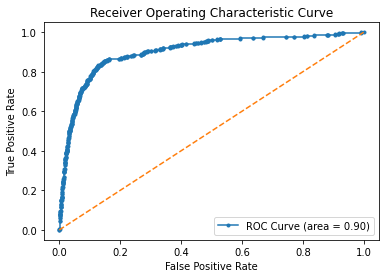

In [99]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # probabilities for the positive class

# Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Output results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)
print("ROC-AUC Score:", roc_auc)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, marker='.', label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

In [100]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': spx500.drop(columns=['evaluation_date', 'masked_consumer_id', 'FPF_TARGET']).columns,
    'importance': best_model.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importance

,feature,importance
10,days_span,112
69,month,83
140,essential_transaction_ratio,75
30,average_GENERAL_MERCHANDISE,68
94,credit_debit_ratio,66
...,...,...
52,debit_volatility,0
111,credit_debit_ratio_2,0
112,credit_debit_ratio_3,0
113,credit_debit_ratio_4,0


In [101]:
important_features = feature_importance[feature_importance['importance'] > 0]['feature'].tolist()
X_important = spx500[important_features]

# Scale features
scaler = StandardScaler()
X_important_scaled = scaler.fit_transform(X_important)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_important_scaled, y, test_size=0.2, random_state=42)

In [102]:
# Define the parameter grid for GridSearchCV
param_dist = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.1, 0.2], 
    'max_depth': [3, 6, -1]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=param_dist,
    scoring='roc_auc',
    cv=5
)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best AUC score from Grid Search:", grid_search.best_score_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Output results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)
print("ROC-AUC Score:", roc_auc)

[LightGBM] [Info] Number of positive: 1569, number of negative: 8593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22618
[LightGBM] [Info] Number of data points in the train set: 10162, number of used features: 97
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.154399 -> initscore=-1.700509
[LightGBM] [Info] Start training from score -1.700509
[LightGBM] [Info] Number of positive: 1569, number of negative: 8593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22614
[LightGBM] [Info] Number of data points in the train set: 10162, number of used features: 97
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.154399 -> initscore=-1.700509
[LightGBM] [Info] Start training from score -1.700509
[LightGBM] [In

In [108]:
cv_scores_accuracy = cross_val_score(best_model, X_important_scaled, y, cv=5, scoring='accuracy')
cv_scores_roc_auc = cross_val_score(best_model, X_important_scaled, y, cv=5, scoring='roc_auc')

print("Cross-Validation Accuracy Scores:", cv_scores_accuracy)
print("Average Accuracy:", cv_scores_accuracy.mean())

print("Cross-Validation ROC-AUC Scores:", cv_scores_roc_auc)
print("Average ROC-AUC:", cv_scores_roc_auc.mean())

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1966, number of negative: 10737
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22672
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 97
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.154767 -> initscore=-1.697695
[LightGBM] [Info] Start training from score -1.697695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

## HistGradientBoostingClassifier

In [104]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_proba = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("AUC:", auc)

d:\Anaconda\envs\deeplearning\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Accuracy: 0.8938916876574308
AUC: 0.9002986579200771


In [107]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# Assuming X and y are your features and target variable
clf = HistGradientBoostingClassifier()
cv_scores_accuracy = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
cv_scores_auc = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')

print("Cross-Validation Accuracy Scores:", cv_scores_accuracy)
print("Average Accuracy:", cv_scores_accuracy.mean())

print("Cross-Validation AUC Scores:", cv_scores_auc)
print("Average AUC:", cv_scores_auc.mean())


Cross-Validation Accuracy Scores: [0.94017632 0.72355164 0.85453401 0.93387909 0.86992126]
Average Accuracy: 0.8644124635554057
Cross-Validation AUC Scores: [0.95624443 0.87317108 0.92975537 0.97414973 0.6229789 ]
Average AUC: 0.8712599026413486
